In [1]:
# Display all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import shutil
import sys
from pathlib import Path

import cv2
import numpy as np
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import torch, torchvision, nvidia.dali, numpy, cv2, PIL

ver = lambda x: f"{x.__name__.ljust(14)}: {x.__version__.rjust(3)}"
print("\n".join(list(map(ver, [torch, torchvision, nvidia.dali, numpy, cv2, PIL]))))

from nvidia.dali import pipeline_def
from PIL import Image
from PIL.ImageDraw import ImageDraw
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms.functional import resize as torch_resize
from torchvision.transforms.functional import to_pil_image, to_tensor

mkdir = lambda x: Path(x).mkdir()


def create_test_img(size=(128, 128), outline_width: int = 3):
    assert size[0] == size[1], f"Square image dimensions expected"

    im = Image.new("RGB", size, color=(255, 255, 255))
    d = ImageDraw(im)
    qtr = int(size[0] / 4)
    pad = int(0.015625 * size[0])
    d.ellipse((qtr, qtr, qtr * 3, qtr * 3), fill=None, outline=0, width=outline_width)
    d.rectangle(
        ((pad, pad), (size[0] - pad, size[1] - pad)), fill=None, outline=0, width=outline_width
    )

    return im


def resize_opencv(img: Image.Image, size=(128, 128), interpolation=cv2.INTER_LINEAR):
    # im = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    im = np.array(img)
    im = cv2.resize(im, size, interpolation)
    return Image.fromarray(im)


def resize_torch(
    img: Image.Image,
    size=(128, 128),
    interpolation=InterpolationMode.BICUBIC,
    antialias: bool = None,
):
    im = torch_resize(to_tensor(img), size, interpolation, antialias=antialias)
    #     return im
    return to_pil_image(im)


def resize_dali(img: str, size=(128, 128), interpolation=types.INTERP_LINEAR, device="gpu"):
    # Setup directory structure for DALI
    if Path("tmp-test").exists():
        shutil.rmtree("tmp-test")
    mkdir("tmp-test")
    mkdir("tmp-test/0")
    img.save("tmp-test/0/test-img.png", quality=100)

    # Define pipeline
    @pipeline_def
    def test():
        imgs, _ = fn.readers.file(file_root="tmp-test")
        imgs = fn.decoders.image(imgs, device="mixed" if device == "gpu" else "cpu")
        imgs = fn.resize(
            imgs,
            device="gpu",
            resize_x=size[0],
            resize_y=size[0],
            mode="stretch",
            interp_type=interpolation,
        )
        return imgs, _

    # Build Pipeline
    pipe = test(batch_size=1, num_threads=1, device_id=0)
    pipe.build()

    # Run Pipeline and get outputs
    img = pipe.run()[0]
    img = img.as_cpu().as_array()[0]  # 0th element of the batch
    assert img.ndim == 3

    return Image.fromarray(img)


torch         : 1.10.0a0+3fd9dcf
torchvision   : 0.11.0a0
nvidia.dali   : 1.5.0
numpy         : 1.21.2
cv2           : 4.5.4-dev
PIL           : 7.0.0.post3


In [3]:
import fastcore.all as fastcore
import operator
from functools import reduce
from typing import List

@fastcore.patch
def __or__(self: Image.Image, other: Image.Image):
    "Horizontally stack two PIL Images"
    assert isinstance(other, Image.Image)
    widths, heights = zip(*(i.size for i in [self, other]))
    
    new_img = Image.new("RGB", (sum(widths), max(heights)))
    x_offset = 0
    for img in [self, other]:
        new_img.paste(img, (x_offset, 0))
        x_offset += img.size[0]
    return new_img

def view_as_row(imgs: List[Image.Image]):
    assert isinstance(imgs, list)
    return reduce(operator.or_, imgs)

### Create Test Image

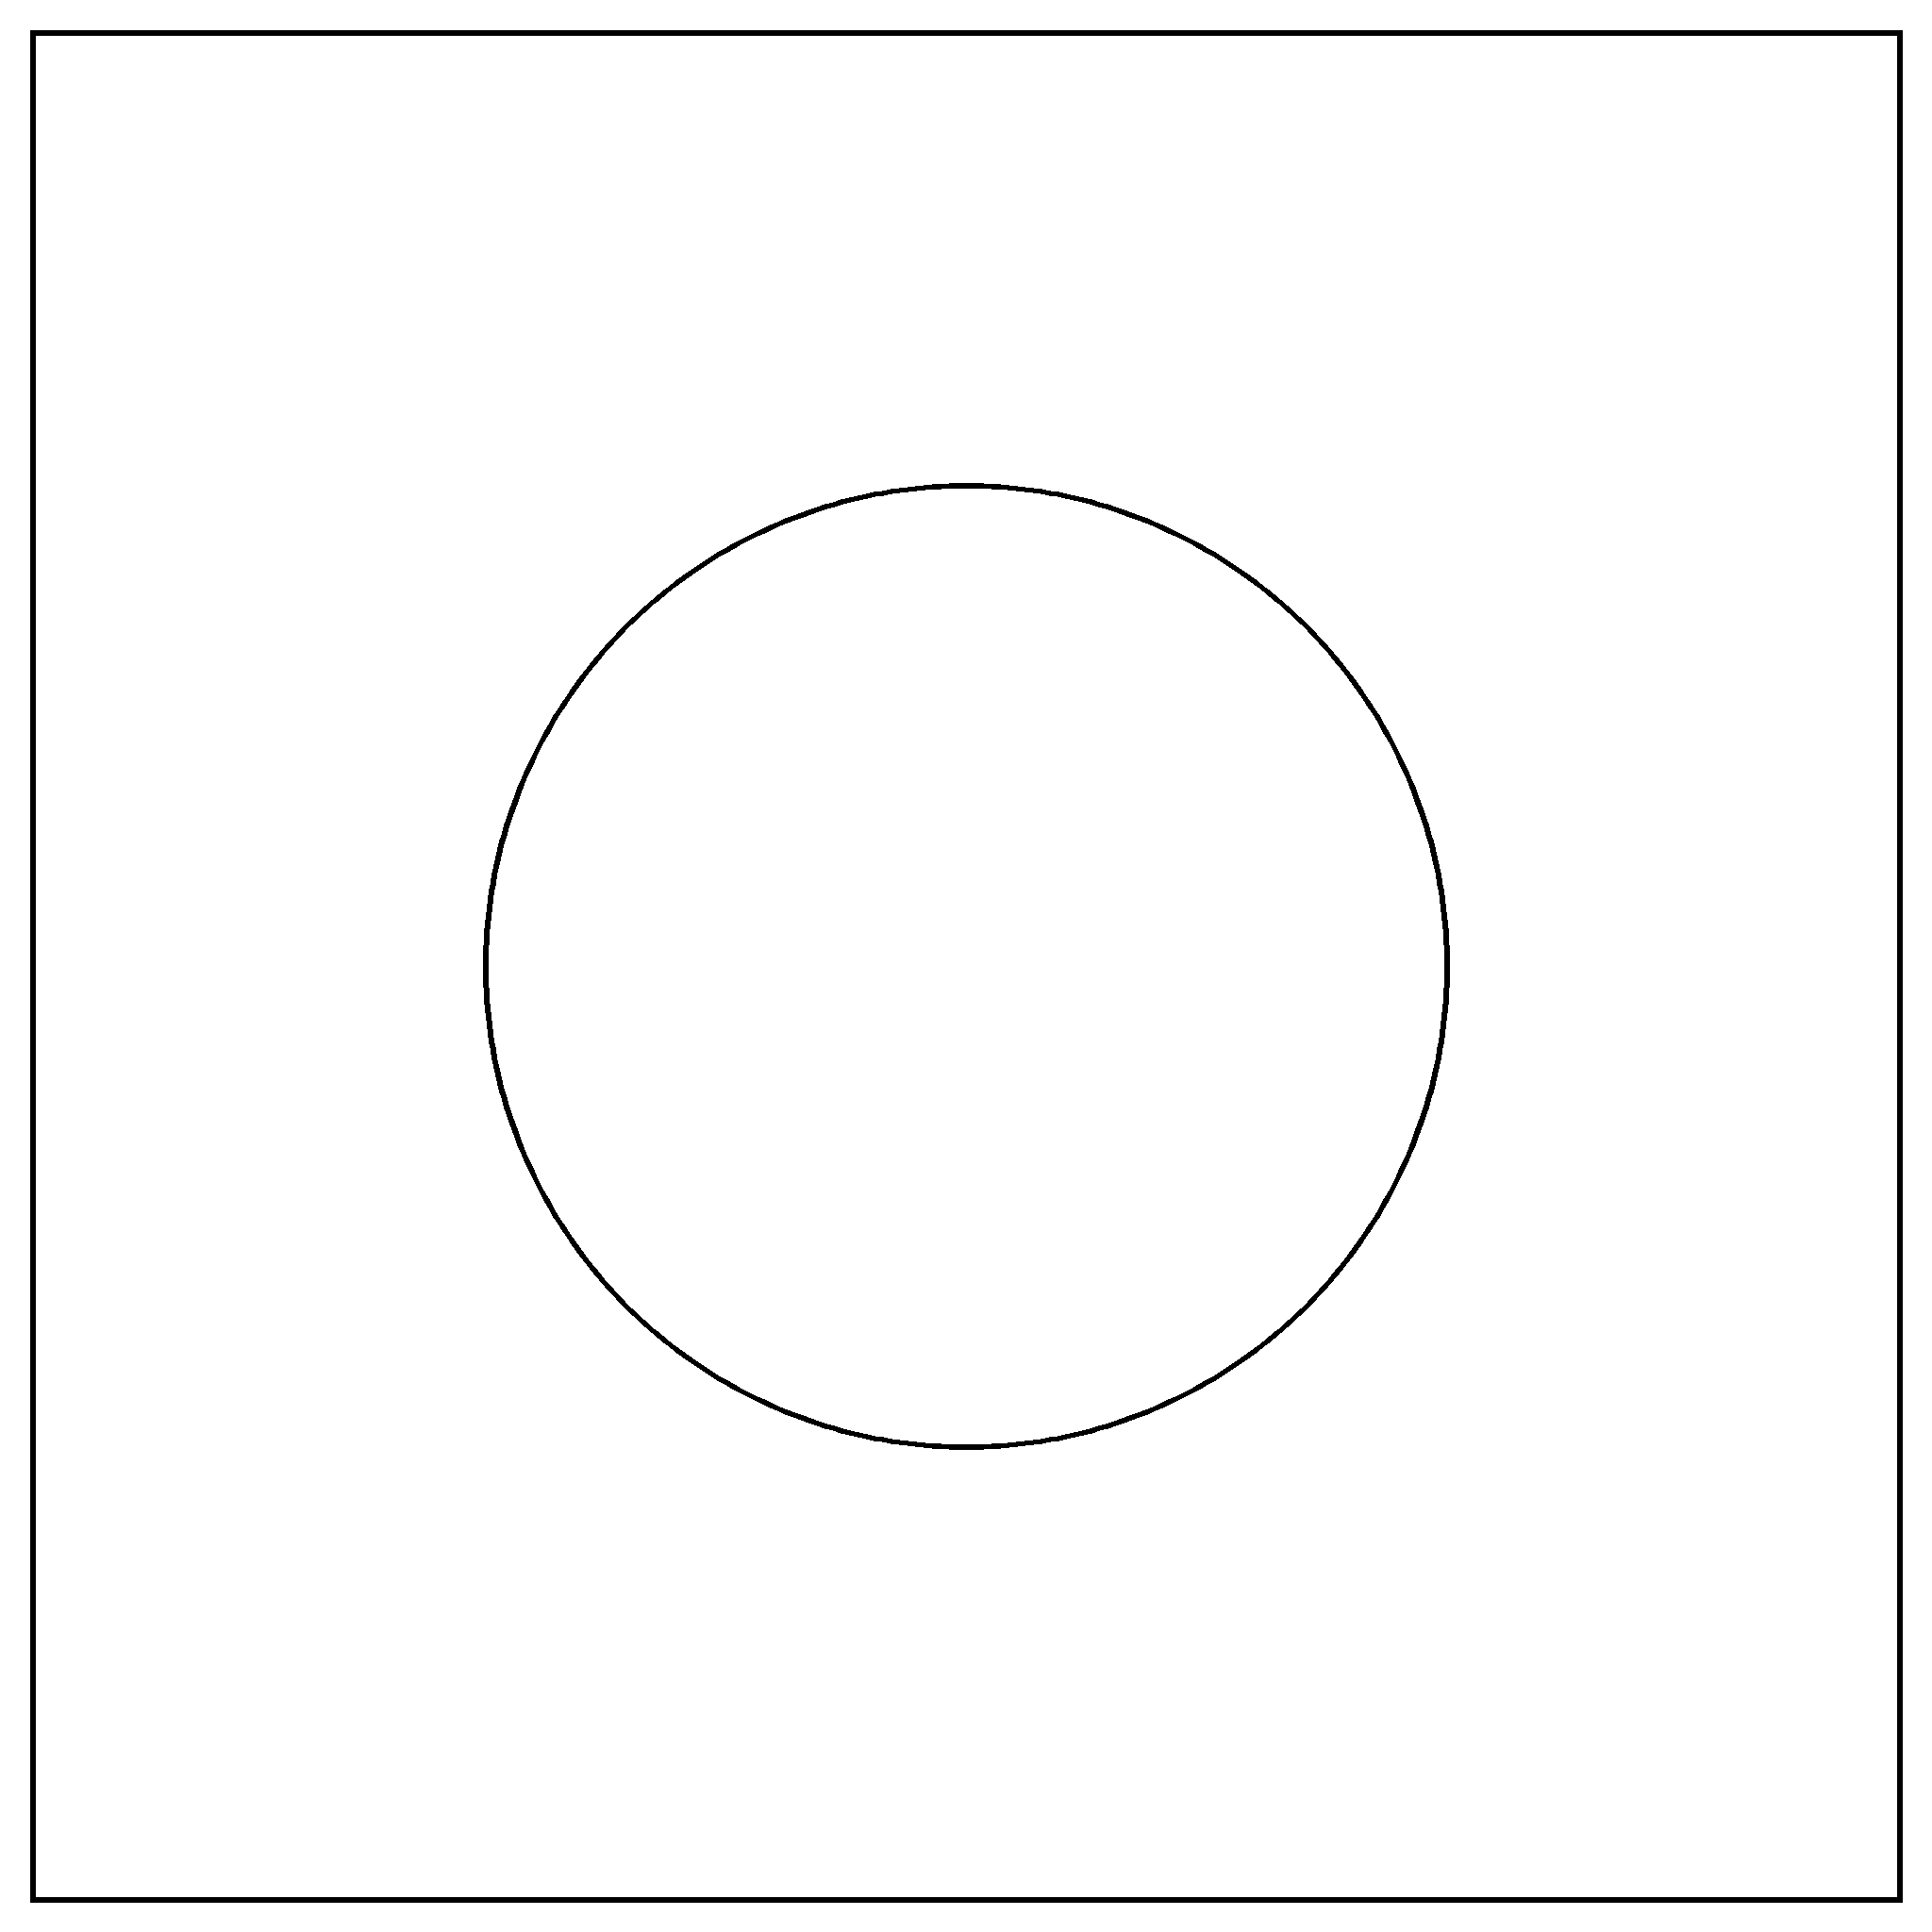

In [4]:
img = create_test_img((2048, 2048), outline_width=6)
size = (224, 224)  # Output size
img

### DALI

#### Correct Outputs

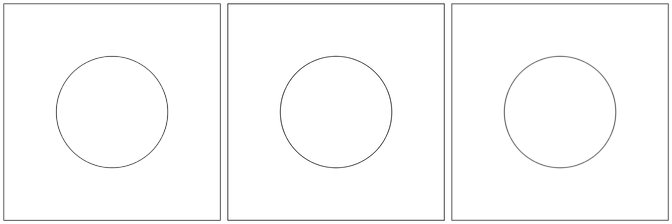

In [5]:
# -- DALI
# --- Correct outputs
results = [
    resize_dali(img, size, interpolation=types.INTERP_GAUSSIAN),
    resize_dali(img, size, interpolation=types.INTERP_LANCZOS3),
    resize_dali(img, size, interpolation=types.INTERP_TRIANGULAR),
]
view_as_row(results)

#### Wrong Outputs

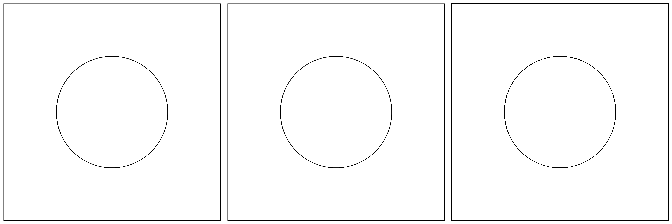

In [6]:
# --- Wrong outputs
results = [
    resize_dali(img, size, interpolation=types.INTERP_CUBIC),
    resize_dali(img, size, interpolation=types.INTERP_LINEAR),
    resize_dali(img, size, interpolation=types.INTERP_NN),
]
view_as_row(results)

### PIL

#### Correct Outputs

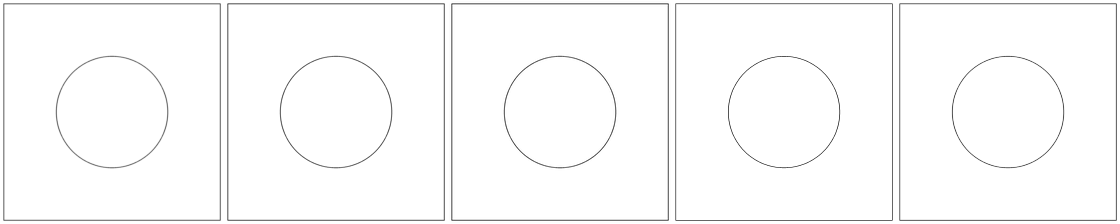

In [7]:
# -- PIL
# --- Correct outputs
results = [
    img.resize(size, Image.BILINEAR),
    img.resize(size, Image.BICUBIC),
    img.resize(size, Image.LANCZOS),
    img.resize(size, Image.BOX),
    img.resize(size, Image.HAMMING),
]
view_as_row(results)

#### Wrong Outputs

In [8]:
# --- Wrong outputs
# None!

###  Torch

#### Correct Outputs

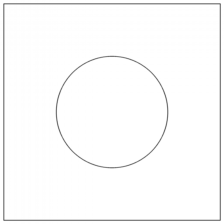

In [9]:
# -- Torch
# --- Correct outputs
resize_torch(img, size, interpolation=InterpolationMode.BILINEAR, antialias=True)

#### Wrong Outputs

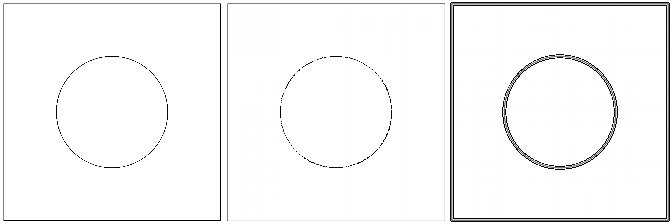

In [10]:
# --- Wrong outputs
results = [
    resize_torch(img, size, interpolation=InterpolationMode.BILINEAR),
    resize_torch(img, size, interpolation=InterpolationMode.BICUBIC),
    resize_torch(img, size, interpolation=InterpolationMode.BICUBIC, antialias=True),
]
view_as_row(results)

### OpenCV

#### Correct Outputs

In [11]:
# -- OpenCV
# --- Correct outputs
# None!

#### Wrong Outputs

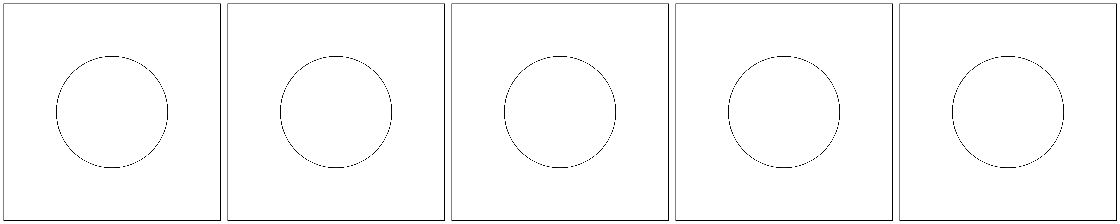

In [12]:
# --- Wrong outputs
results = [
    resize_opencv(img, size, cv2.INTER_NEAREST),
    resize_opencv(img, size, cv2.INTER_LINEAR),
    resize_opencv(img, size, cv2.INTER_AREA),
    resize_opencv(img, size, cv2.INTER_CUBIC),
    resize_opencv(img, size, cv2.INTER_LANCZOS4),
]
view_as_row(results)